# Before you start

Before you start this lab you'll need to install some additional packages in your conda environment. These packages are scikit-learn (sklearn), pandas and gensim. The getting started guidelines have been updated to include these packages.

You'll also need to download the file 'wiki.simple.vec' from Canvas, which contains word embeddings that will be used in this exercise. Do **NOT** include 'wiki.simple.vec' in your submission of this exercise.

The code for this exercise is only to be used for educational purposes.

# Introduction
Natural Language Processing (NLP) is a set of techniques and algorithms that use computers for analyzing natural human language.  NLP can be used to solve a variety of problems, for example:

* Subject Matter Identification - What are the topics, people, companies or places discussed in this text?
* Sentiment Analysis - Does this text convey a positive, negative or neutral feeling about an entity or subject matter?
* Machine Translation - Convert the input from one language to another, for example, from English to French
* Text-to-Speech - Convert the spoken input into its written form
* Understanding and Interpretation - What information will answer a specific question?

Early NLP systems used rules manually designed by domain experts.  As the field advanced, the use of machine learning enabled the application of more powerful models that took advantage of ever-growing amounts of data.  In this exercise we are taking advantage of Deep Learning to tackle ever more complex NLP tasks.

In this lab we will focus on the following:
1. The bag-of-words representation and its shortcomings
2. Computing word embeddings using the Word2Vec algorithm
3. Applying pre-trained word embeddings to a text classification problem




# The Importance of Data Representation in NLP

One of the most important issues that data scientists encounter is how to represent their data to an algorithm.  This is especially relevant in NLP where inputs often differ in lengths, taking the form of sentences or even entire documents. Regardless of input length it is important to develop a representation that can capture similar themes and/or uses of domain-specific terms and vocabulary. We will demonstrate this using examples from Brian Wildsmith's wonderful children's book 'Cat on the Mat'.

### Bag-of-Words Representation
A common way of representing text is using the Bag-of-Words (BoW) approach, where we simply count the number of occurrences of each word in our *corpus*, a collection of individual texts or *documents*, for each individual item in the collection:

NOTE: The exercises in this section are for warmup so there's hints containing most of the solution.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import HTML

corpus = ['The cat sat on the mat', 'The dog sat on the mat', 'The goat sat on the mat']

vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=False)
representation = vectorizer.fit_transform(corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df

,cat,dog,goat,mat,on,sat,the
0,1,0,0,1,1,1,2
1,0,1,0,1,1,1,2
2,0,0,1,1,1,1,2


For this representation we count how often a word appears in a given input. This count is typically referred to as a *term frequency*. The collection of all unique words for a corpus is referred to as the *vocabulary* for the corpus. In the Bag-of-Words representation, the size of the vocabulary plays a significant factor in the size of the representation of the text.



A similar representation uses a binary value for each word as opposed to a discrete count. This is often referred to as a one-hot encoding. It has the advantage of being relatively compact because each word in a vocabulary is represented using a single bit. This representation is frequently used when term frequency is irrelevant to the application at hand.

We use the *CountVectorizer* object from Python's Scikit-Learn package of Machine Learning tools and algorithms.  See the API for CountVectorizer [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

**Exercise**: Use the CountVectorizer object to create a binary value for each word.  See [here](#hint1 "Use the binary= argument to the constructor") if you need a hint.

In [2]:
vectorizer = CountVectorizer(binary=True) ##TODO## : Use CountVectorizer to create a binary value for each word
representation = vectorizer.fit_transform(corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df

,cat,dog,goat,mat,on,sat,the
0,1,0,0,1,1,1,1
1,0,1,0,1,1,1,1
2,0,0,1,1,1,1,1


In many cases it is often beneficial to drop *stop words*, such as *the*, *on*, *in* and similar, because they appear frequently, do not add meaning to the text and otherwise require resources to represent. Stop words differ between languages and lists for some languages are available from [https://www.ranks.nl/stopwords](https://www.ranks.nl/stopwords). Dropping stopwords can reduce vocabulary size and thus the overall size of a representation.

**Exercise**:  Use the CountVectorizer object to remove English stop words.  See [here](#hint2 "Use the stop_words= argument to the constructor") for a hint.

In [3]:
vectorizer = CountVectorizer(binary=True, stop_words='english') ##TODO## : Use CountVectorizer to remove English stopwords
representation = vectorizer.fit_transform(corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df

,cat,dog,goat,mat,sat
0,1,0,0,1,1
1,0,1,0,1,1
2,0,0,1,1,1


There are other ways to represent word counts such as [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) that takes into account how often a word appears in document in comparison to how often the word appears in a given corpus. This gives some weight to words that appear less frequently and de-emphasises common, more frequent words.

#### Issues with the Bag-of-Words Representation

BoW is a good way to represent textural data and has been effectively used for regularly achieving 70-80 percent accuracy on various NLP tasks quickly and efficiently.  However, it suffers from three primary shortcomings:
1.  Invariance to word order
2.  Lack of semantic generalization
3.  The representations are large, yet sparsely populated

We will investigate each in turn.

##### Invariance to Word Order
In the above examples, notice that the BoW representation is unable to capture the original order in which the words appeared in the corpus.  To explore this concept further, consider the representation of sentences that use the same words but differ only in their ordering:


In [4]:
ordering_corpus = ['The cat sat on the mat', 'the mat sat on the cat', 'Mat the cat the sat']
ordering_vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=True, stop_words='english')
representation = ordering_vectorizer.fit_transform(ordering_corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(ordering_vectorizer.vocabulary_.keys()))
representation_df

,cat,mat,sat
0,1,1,1
1,1,1,1
2,1,1,1


Note that the representations are all identical.  In particular, note that the second sentence - unless used in a comical or cynical context - makes no sense and the third is not even grammatically correct in English.  While word order invariant representations are often sufficient for simple tasks, the inclusion of word order is required for achieving higher accuracy in many cases.

##### Lack of Semantic Generalization
Looking at original corpus of sentences above, it is clear that we can formulate them in the following manner:

*The X sat on the mat*

where *X* is an animal:  cat, dog or goat.  How are these represented in BoW?

In [5]:
vectorizer.vocabulary_

{'cat': 0, 'dog': 1, 'goat': 2, 'mat': 3, 'sat': 4}

So *cat* is the first feature (will appear in position 0 of a 1-hot encoded vector), *dog* is the second (position 1 of the vector) and so on.  It appears that in this case features are sorted by alphabetical order.  We can check by adding another animal, one that appears before *cat*:

In [6]:
feature_corpus = ['The cat sat on the mat', 'The dog sat on the mat', 'The bird sat on the mat']
feature_vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=True, stop_words='english')
representation = feature_vectorizer.fit_transform(feature_corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(feature_vectorizer.vocabulary_.keys()))
representation_df

,bird,cat,dog,mat,sat
0,0,1,0,1,1
1,0,0,1,1,1
2,1,0,0,1,1


Now *bird* is the first feature, *cat* is the second and *dog* is the third.  

In the book, we have multiple animals that sit on the mat (cat, dog, goat, elephant).  This implies that only animals are able to sit on the mat while other objects are not.  Let's now attempt to build a simple classification model for deciding whether *X on the mat* is an allowed state-of-affairs or not - in other words, a text classification problem.

Note:  after running the cell below, please make sure that you do not change the contents of the *vectorizer* variable.

In [7]:
training_corpus = ['The cat sat on the mat', 'The dog sat on the mat', 'The goat sat on the mat', 'The elephant sat on the mat', 
          'The plane sat on the mat', 'The apple sat on the mat', 'The pen sat on the mat', 'The notebook sat on the mat']

allowed = [1,1,1,1,   # Objects that are allowed on the mat
           0,0,0,0]   # Objects that are not allowed on the mat

# Make sure that words we'll use in the test set are considered
for other_object in ['keyboard', 'bird']:
    training_corpus.append(other_object)   
    
vectorizer = CountVectorizer(lowercase=True, analyzer='word', binary=True, stop_words='english')
representation = vectorizer.fit_transform(training_corpus)
representation_df = pd.DataFrame(data = representation.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))
representation_df

,apple,bird,cat,dog,elephant,goat,keyboard,mat,notebook,pen,plane,sat
0,0,0,1,0,0,0,0,1,0,0,0,1
1,0,0,0,1,0,0,0,1,0,0,0,1
2,0,0,0,0,0,1,0,1,0,0,0,1
3,0,0,0,0,1,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,1,1
5,1,0,0,0,0,0,0,1,0,0,0,1
6,0,0,0,0,0,0,0,1,0,1,0,1
7,0,0,0,0,0,0,0,1,1,0,0,1
8,0,0,0,0,0,0,1,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logistic = LogisticRegression()
y = allowed
X = representation_df[:len(y)]

logistic.fit(X,y) # Only train on the first 8 sentences
print("Training accuracy score is:  {} %".format(accuracy_score(logistic.predict(X), y)*100.0))

Training accuracy score is:  100.0 %


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


We see that a simple [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model (which is functionally equivalent to a single layer perceptron with logistic activation function) is able to learn our training data perfectly - animals are allowed on the mat, other objects are not.  Let's now see whether our model is able to *generalize* to other animals and objects:

**Exercise**:  Transform the sentences in the test corpus into a BoW representation.  See [here](#hint3 "X_test = vectorizer.transform(test_corpus)") for the answer.

In [9]:
test_corpus = ['The keyboard sat on the mat', 'The bird sat on the mat']
X_test = vectorizer.transform(test_corpus)
y_test = [0,1]
print("Expected Results for (keyboard, bird):  {}".format(y_test))
print("Actual   Results for (keyboard, bird):  {}".format(logistic.predict(X_test)))
pd.DataFrame(data = X_test.toarray(), columns=sorted(vectorizer.vocabulary_.keys()))

Expected Results for (keyboard, bird):  [0, 1]
Actual   Results for (keyboard, bird):  [0 0]


,apple,bird,cat,dog,elephant,goat,keyboard,mat,notebook,pen,plane,sat
0,0,0,0,0,0,0,1,1,0,0,0,1
1,0,1,0,0,0,0,0,1,0,0,0,1


We see that this simple model was unable to capture the generalization that animals are allowed on the mat.  Perhaps a more powerful model would have been able to do this.  However, we would ideally like the notion of *animal* - a semantic concept - to be captured directly in the input representation if possible.  In other words, we'd like a representation that is 'smarter' in itself, regardless of the algorithm used.

##### Sparseness
In the BoW representation, every word is a feature.  So for large corpora, this means that a 1-hot encoded vector for a single sentence can be very long.  For example, in a vocabulary with 1000 words and 10 words per sentence, a single input vector will be 1000 x 10 
= 10000 parameters.  A large corpus can easily contain many more words, and sentences can easily be 30 or 40 words long. The problem of large vocabularies and the computational complexity they bring is sometimes referred to as 'the curse of dimensionality'

In addition, a single sentence normally contains only a small fraction of all possible words in the vocabulary.  This means that most values in our input will have the value 0. This is known as a sparse representation because the representation is only sparsely populated with data.  The result is that we have many parameters which in turn will require the use of a large amount of data for training a model or risk overfitting.  It is possible to use only the top *k* words from a vocabulary (as the [distribution of words in natural language](https://en.wikipedia.org/wiki/Zipf's_law) tends to have a small number of very frequent words), but this is only a stopgap measure and does not directly address the problem.

# Distributed Representations, aka Word Embeddings


Now that we have seen some of the issues that affect the BoW representation, how can Deep Learning help?  In this section we discuss how to create better representations using techniques based on neural networks.  

### Some Help from Theoretical Linguistics

In order to get a good intuition for word embeddings, it is helpful to look at the [Distributional Hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics#Distributional_hypothesis) which was first formulated in the context of Linguistics, specifically, statistical semantics:

> A word is characterized by the company it keeps 

> (Firth, 1957)

In simple terms, the Distributional Hypothesis states that words that appear in similar *syntactic* contexts tend to have similar *semantic* meanings.  Stated differently:  words have similar meanings when the words that precede and/or follow them are the same.  Using our examples from above and designating the animal in each sentence as X:

The *cat* sat on the mat

The *dog* sat on the mat

The *elephant* sat on the mat

In all of those examples X is preceded by the word 'The' and followed by the words 'sat on'. More specifically, X is preceded by the sequence '`<PAD>` The', where `<PAD>` signifies a padding value used to indicate the beginning or ending of a sentence. This is known as a *context* of 2 words, with two 'words' captured on either side of the target word.  Indeed by definition all of these X's have something in common - they are animals.  Let's compare those examples to the following:

The *quickly* sat on the mat

Obviously, with the sentence being non-grammatical, the word *quickly* does not appear in the same context as our animals.  
How about a valid sentence?

The *monitor* sat on the mat

While a noun in the position of X is grammatical, it does not make semantic sense and would probably not be used in regular, everyday speech.  By applying the Distributional Hypothesis we can now assume that *quickly* and *monitor* are not semantically similar to animals based on the text that we have available.



### Computing Word Embeddings

From a mathematical viewpoint, embeddings are a [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) technique.  In the BoW representation, every unique word is a single dimension, and there are $|V|$ dimensions altogether (where $V$ is the set of all words in the corpus).  Embeddings, on the other hand, are lower-dimensional, usually between 50 and 300 dimensions. Embeddings are also dense vectors, typically possessing a value for each of the dimensions present.  Each dimension is essentially a *latent factor* that encodes some information about that particular word.  Therefore, embeddings are also known as *distributed representations*.    

Embeddings possess a particularly interesting property:  when trained on a large corpus, those latent factors tend to encode semantics from the corpus' domain!  In other words, the model learns concepts and ideas that are specific to that domain.  Probably the most well-known example is from Mikolov et al's 2013 influential [paper](https://arxiv.org/pdf/1301.3781.pdf)):

*vector('king') - vector('man') + vector('woman') ~= vector('queen')*

That is, when subtracting the embedding of 'man' from the embedding of 'king' and following that with the addition of the embedding of 'woman' (keeping in mind that embeddings are just vectors), the closest embedding to the result is the one for the word 'queen'.  Other examples are given in the paper from Mikolov.

The paper just discussed introduces Word2Vec - an algorithm for computing word embeddings.  In this lab, we will compute word embeddings for a small corpus using this algorithm.  Specifically, we will use the *skip-gram* variant of the algorithm (the paper also describes a variant called *Continuous Bag-of-Words* or *CBOW* - see below). 


### Word2Vec  Skip-gram

![](https://cdn-images-1.medium.com/max/800/1*SR6l59udY05_bUICAjb6-w.png)
*Skip-gram architecture, source: Mikolov et al.*


The skipgram algorithm functions by selecting pairs of target and context words and training a model to recognize whether the context word appears in the context window of the target.  For example, given the sentence *the cat sat on the mat*, the target word *sat* and a context window size of 1, the (target, context) pairs will be:
* (sat, cat)
* (sat, on)

For a context window of size 2, an additional pair will be added: 
* (sat, the)  (note that 'the' appears both 2 words before and after 'sat')

We begin by creating a model with two inputs, namely the target and context words.  Next, we add an *embedding layer*.  This layer is a matrix of size $|V|\times d$, with $V$ as defined above and $d$ as the dimension of the embedding (which is a hyper-parameter).  Essentially, the embedding layer serves as a lookup table, where the (1-hot encoded) target and context words each select a single row (i.e., vector) from the matrix.  This row is the embedding, and it is up to our algorithm to learn it.

The next step is to compute a similarity score between the two vectors using the dot product operator.  As explained above, words that are in similar contexts tend to have semantic similarities - hence we would like our model to learn that each (target, context) pair should have a high similarity score.  

Finally, we use a technique called *negative sampling*.  In negative sampling, not only do we choose (target, context) pairs from a given sentence - we also choose pairs that *do not* appear in the sentence - i.e., (target,not(context)).  For these pairs, we would like the similarity score to be low.  An example for the same sentence:

* (cat, sat) - Positive sample
* (cat, dog) - Negative sample

As such, our input dataset consists of (target, context) pairs and a labels which are either 0 or 1, depending on whether this pair is a positive or negative sample.  Note that while we have labels, this is actually an *unsupervised* problem, as we generate the labels directly from the text.  Therefore, it is possible to run this algorithm on large amounts of text without human involvement.  The algorithm will then produce embeddings that are specific to that corpus.

For this lab, we will extend our corpus by adding more animals, as well as adding further actions and even nouns that denote furniture.  Recall that words for each category are semantically similar, as they appear in the same contexts.

In [10]:
import itertools

animals = ['cat','dog','goat','elephant','eagle','zebra','rhino', 'hippo']
actions = ['sat','stood','jumped','slept']
furniture = ['mat','rug','sofa','bed']

# Generate all combinations of animal, action and furniture
animal_corpus = ['The {} {} on the {}'.format(x[0], x[1], x[2]) for x in itertools.product(animals, actions, furniture)]
vocabulary_size = len(animals) + len(actions) + len(furniture) + 2

print("There are {} sentences in the corpus, with a vocabulary of {} words".format(len(animal_corpus), vocabulary_size))

There are 128 sentences in the corpus, with a vocabulary of 18 words


Once we have a corpus, we use PyTorch model construction. The initial step is to convert each sentence into a sequence of numbers, where each word has a unique index to be used in a 1-hot encoding.  While this construction is very similar to what happens in Bag-of-Words, the representation will only be used to train the embeddings and *not* for any additional, downstream NLP tasks. 

The *Tokenizer* object breaks sentences into words, lower-cases them and gets rid of any special characters such as punctuation.  It then assigns each word a unique index (as we just described).  The *skipgram* function then creates the (target, context) pairs.  We configure it to use negative sampling and have use a hyper-parameter for the context window size.  Interestingly, note that we do not drop stopwords here.

In [0]:
import numpy as np
import re
import random

# This is code for the Tokenizer (you don't need to understand it)
class Tokenizer():
    def __init__(self, num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' '):
        self.num_words = num_words,
        self.filters = filters
        self.lower = lower
        self.split = split
        self.word_index = {'[OOV]':0}
        self.index_word = ['[OOV]']
    
    def get_word_index(self, word):
        if word in self.word_index:
            return self.word_index[word]
        else:
            return 0
    
    def prepare_texts(self, corpus):
        texts = []
        for text in corpus:
            text = re.sub('['+self.filters+']', '', text)
            if self.lower:
                text = text.lower()
            words = text.split(self.split)
            texts.append(words)
        return texts
    
    def fit_on_texts(self,corpus):
        corpus = self.prepare_texts(corpus)
        words = sum(corpus, [])
        for word in words:
            if len(self.index_word) == self.num_words:
                    return
            if not word in self.word_index:
                self.word_index[word] = len(self.index_word)
                self.index_word.append(word)
                
    def texts_to_sequences(self, corpus):
        corpus = self.prepare_texts(corpus)
        return [[self.get_word_index(word) for word in text] for text in corpus]

# This is code for the skipgram generation (you don't need to understand it)
def skipgrams(sequence, vocabulary_size, window_size = 4, negative_samples = 1, shuffle = True):
    couples = []
    labels = []
    for i, wi in enumerate(sequence):
        if not wi:
            continue
            
        window_start = max(0, i - window_size)
        window_end = min(len(sequence), i + window_size + 1)
        for j in range(window_start, window_end):
            if j != i:
                wj = sequence[j]
                if not wj:
                    continue
                couples.append([wi, wj])
                labels.append(1)

    if negative_samples > 0:
        num_negative_samples = int(len(labels) * negative_samples)
        words = [c[0] for c in couples]
        random.shuffle(words)

        couples += [[words[i % len(words)], random.randint(1, vocabulary_size - 1)] for i in range(num_negative_samples)]
        labels += [0] * num_negative_samples

    if shuffle:
        seed = random.randint(0, 10e6)
        random.shuffle(couples)
        random.shuffle(labels)

    return couples, labels

In [12]:
# Hyper-parameters

EMBEDDING_SIZE = 7  # Small corpus, so we're using a small dimension
WINDOW_SIZE = 4     # Empirically found to work well

# Convert text to numerical sequences

# Note that the Tokenizer starts numbering words with 1.  So we have vocabulary_size+1 words.  The 0-th word
# is considered to be the 'Out-of-vocabulary' token.
tokenizer = Tokenizer(num_words=vocabulary_size+1, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ',)
tokenizer.fit_on_texts(animal_corpus)
sequences = tokenizer.texts_to_sequences(animal_corpus)

# Generate (target, context) pairs with negative sampling

pairs = []
labels = []

for this_sequence in sequences:
    # Again note the vocabulary_size+1 expression
    c, l = skipgrams(this_sequence, vocabulary_size+1, window_size=WINDOW_SIZE, negative_samples=1, shuffle=True)
    for i in range(len(c)):
        pairs.append(c[i])
        labels.append(l[i])
pairs = np.array(pairs)
labels = np.array(labels)
    
print("There are {} (context,target) pairs in the dataset".format(len(pairs)))

There are 7168 (context,target) pairs in the dataset


We now build and train the model.

**Exercise**: For this exercise we'll be creating our own PyTorch Module. Just like nn.Sequential can be used to create a numpy model with many modules, we can define our own class. The advantage of using your own class is that the network doesn't have to be strictly linear. In this case when using skipgrams we want to input two integers representations of words, extract their embeddings, calculate the dot product, and then predict if they are in the same window or not.

The \__init__() function is where we define the components of our Module. For this task this has already been done.
The forward() function is the function that is called when a Module is given data as input. Your task is to complete the forward() function by completing the unfinished lines of code.

To do the dot product we do first simple multiplication and then sum the resulting vector. The sum function is implemented in PyTorch so you should be able to find it online if you get stuck.

The cell below that will train the network and does not need to be changed.

In [0]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SkipgramEmbedder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(vocabulary_size+1, EMBEDDING_SIZE,)
        self.output_layer = nn.Linear(1,1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, target_word, context_word):
        ##TODO## : Extract the embedding of the target word from the embedding layer
        target_embedding = self.embedding_layer(target_word)
        ##TODO## : Extract the embedding of the context word from the embedding layer
        context_embedding = self.embedding_layer(context_word)
        output = torch.sum(target_embedding * context_embedding, dim=1)
        output = output.unsqueeze(-1) # Adding an inner dimension to make PyTorch differentiate batches from data 
        output = self.output_layer(output) ##TODO## : Run the sum through the output layer
        output = self.sigmoid(output) ##TODO## : Normalize the output layer with a sigmoid function
        return output

model = SkipgramEmbedder()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
loss_function = nn.BCELoss()


In [19]:
#Epochs
TOTAL_EPOCHS = 500
BATCH_SIZE = 256

# For each epoch
for epoch in range(TOTAL_EPOCHS):
    
    # A variable for containing the sum of all batch losses for this epoch
    epoch_loss = 0
    
    # Lower index
    start = 0
    
    # For each batch
    for batch_nr, end in enumerate(range(BATCH_SIZE,len(labels),BATCH_SIZE)):
        
        targets = torch.Tensor(pairs[start:end,0]).long()
        contexts = torch.Tensor(pairs[start:end,1]).long()
        label = torch.Tensor(labels[start:end])
        
        start = end
        
        # Predict for each digit in the batch whatclass they belong to
        prediction = model(targets, contexts)
        
        # Calculate the loss of the prediction by comparing to the expected output
        loss = loss_function(prediction, label)
        
        # Backpropogate the loss through the network to find the gradients of all parameters
        loss.backward()
        
        # Update the parameters along their gradients
        optimizer.step()
        
        # Clear stored gradient values
        optimizer.zero_grad()
        
        # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
        epoch_loss += loss.item()
        
        #Print the epoch, batch, and loss
        print(
            '\rEpoch {} [{}/{}] - Loss: {}'.format(
                epoch+1, batch_nr+1, len(labels)/BATCH_SIZE, loss
            ),
            end=''
        )


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 500 [27/28.0] - Loss: 0.6921418309211731

We discussed the fact that embeddings capture the semantics inherent in the corpus.  Hence, it would be interesting to look 'inside' our results.  We'll try a dimensionality-reduction operation so that we can plot the learned representations on a 2-D plane (our computer screen).  One possible technique is [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis). You can read more about PCA in [Section 2.12 in the course book Deep Learning](http://www.deeplearningbook.org/contents/linear_algebra.html). We use the PCA functionality in Python's [Scikit-Learn](http://scikit-learn.org/stable/index.html) library, and color the embeddings based on their categories.  'Good' embeddings will show up as well-defined clusters - individual words will be closer to words of the same category than to words of other categories.  Try running the previous cell multiple times and observe the results.

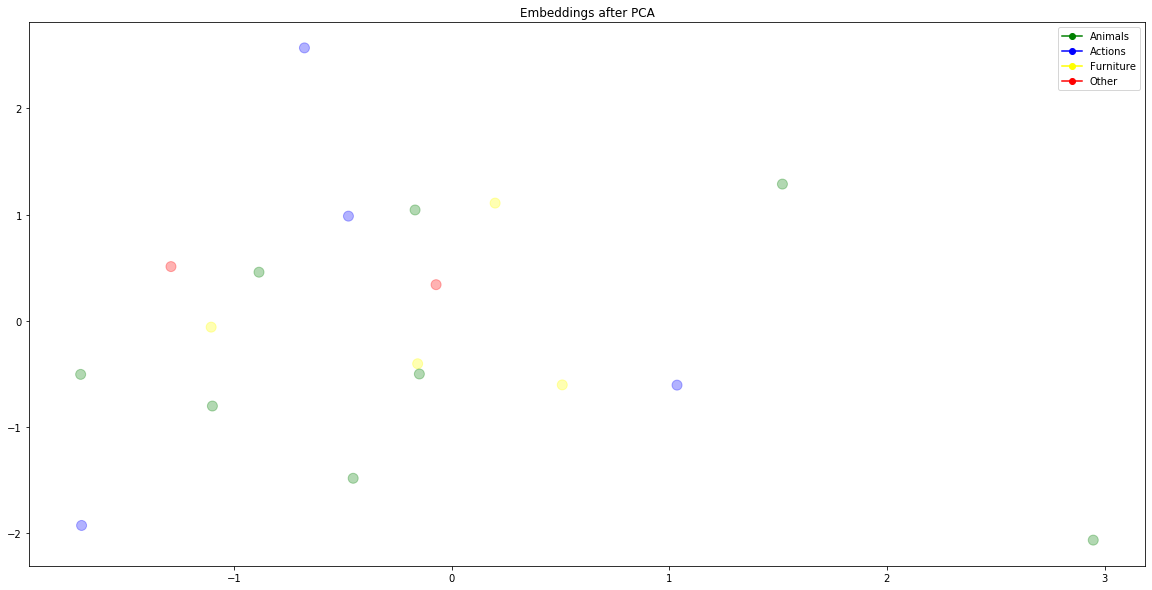

In [20]:
%matplotlib inline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


category_colors = {'animals' : 'green', 
                   'actions' : 'blue',
                   'furniture' : 'yellow'}

colors = []
for i in range(vocabulary_size):
    colors.append('red')
    
for word in tokenizer.word_index:
    index = tokenizer.word_index[word] -1
    if word in animals:
        colors[index] = category_colors['animals']
    elif word in actions:
        colors[index] = category_colors['actions']
    elif word in furniture:
        colors[index] = category_colors['furniture']

# Plots embeddings using PCA (you don't need to understand it)
def plot_embeddings_after_pca(vectors):  
        """
        Perform PCA and plot the resulting 2 components on X and Y axis
        Args:
          embedding_weights - the set of vectors to 
        """
        pca = PCA(n_components=2)
        vectors_pca = pca.fit_transform(vectors)
        plt.figure(figsize=(20,10))
        
        # We do not draw the first element, which is the 'Out-of-Vocabulary' token
        plt.scatter(vectors_pca[1:,0], vectors_pca[1:,1], c=colors, s=100, alpha=0.3);
        plt.title('Embeddings after PCA')
        legend_elements = [
                    plt.Line2D([0], [0], marker='o', color=category_colors['animals'], label='Animals'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['actions'], label='Actions'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['furniture'], label='Furniture'),
                    plt.Line2D([0], [0], marker='o', color='red', label='Other'),
                  ]

        # Create the figure
        plt.legend(handles=legend_elements);

# Extracting the embeddings for every word in the vocabulary, detaching them from PyTorch, and turning them into numpy
numpy_word_vectors = model.embedding_layer(torch.Tensor(range(vocabulary_size+1)).long()).detach().numpy()

# Display the most significant axes of the word vectors using PCA
plot_embeddings_after_pca(numpy_word_vectors)






#### Exercise
1.  Experiment with embedding and context window sizes to get some intuition for how they affect the final results.
*Reducing window size strangely led to better loss, but the graph was centered (so worse, less splitted)*
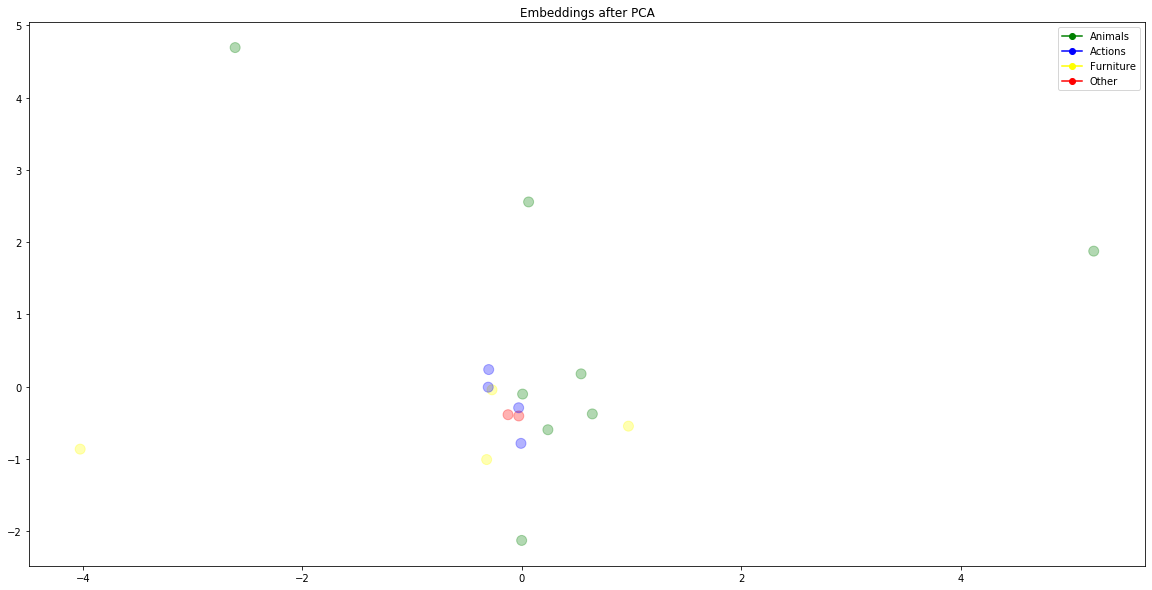 
*Increasing it over 5 did not improve anything but the point were scattered.*
2.  Try replacing the dot product operation with other ways of combining two vectors (like subtraction, minumum, concatenation, etc). How do these affect the embedding quality?
*Replacing multiplication with substraction was strangely better* 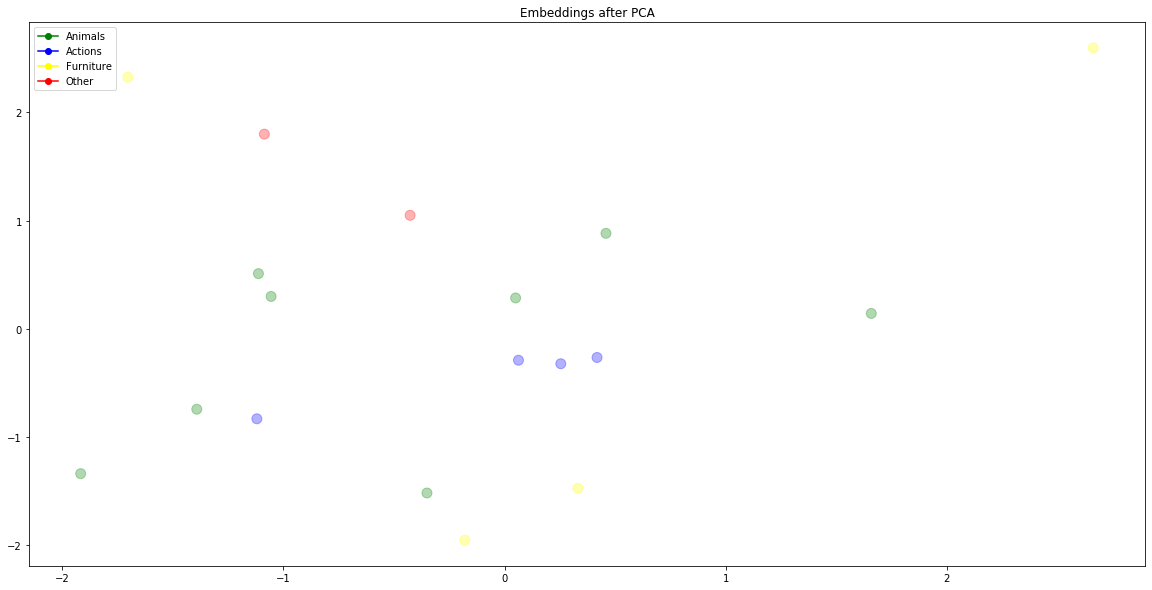
3.  How does the choice of epochs and/or optimizer affect the embedding quality?
*Changing epochs don't change since much since about 300 is way sufficient. Changing optimizer affet speed : RMSprop and Adagrad were as fast, where SGD was way slower, but didn't oscillate.*

### Code Exercise - Implementing CBoW

In the previous section, we experimented with the *skip-gram* version of Word2Vec.  As mentioned, there is also a different variant named *Continuous Bag-of-Words (CBoW)*.  Recall that the Bag-of-Words representation does not take word order into account.  The CBoW approach is similar - but generates distributed representations in contrast to the discrete and sparse representation generated by BoW.

In this section, you will implement the CBoW approach from Word2Vec.

#### CBoW Approach

![](https://cdn-images-1.medium.com/max/800/1*UVe8b6CWYykcxbBOR6uCfg.png)
*CBoW architecture, slightly modified from Mikolov et al.*

In contrast to skip-grams, CBoW considers all words on each side of the target word simultaneously.  In the figure above, $w(t-1)$ and $w(t-2)$ are the embeddings of the context words that appear to the left of the target word while $w(t+1)$ and $w(t+2)$ are those content words that appear to the right.  In this case, the window size is 2, and in total there are 4 context words.  Once the context words are identified, the next stage is taking the *mean* of the context embeddings.  In truth, any operation that merges the context embeddings could work, such as $sum$. At this point, word order is lost and this is where the Bag-of-Words name derives from. From there on, it is a simple matter of attaching a [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation for selecting the 1-hot encoded context word (denoted $w(t)$).

The following cell contains the code to generate sequences of length *window_size*, along with the 1-hot encoded representation of the context word.

In [0]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

window_size = 2

# Takes the data and extracts the word (y) and its context (X)
def make_cbow_data(sequences, window_size):
    X = []
    y = []
    num_classes = len(np.unique(np.hstack(sequences)))+1
    for this_sequence in sequences:
        for output_index, this_word in enumerate(this_sequence):
            this_input = []
            y.append(this_word)
            input_indices = [output_index - i for i in range(window_size,0,-1)]
            input_indices += [output_index + i for i in range(1, window_size+1)]
            for i in input_indices:
                this_input.append(this_sequence[i] if i >= 0 and i < len(this_sequence) else 0)
            X.append(this_input)
    return num_classes, np.array(X),np.array(y)
                
   
        
num_classes, cbow_X, cbow_y = make_cbow_data(sequences, window_size)
print("cbow_X shape: {}".format(cbow_X.shape))
print("cbow_y shape: {}".format(cbow_y.shape))

cbow_X shape: (768, 4)
cbow_y shape: (768,)


**Exercise**
This exercise is similar to the skipgram embedder in that it too requires you to finish an incomplete nn.Module. However the CBoW embedder only takes a single input (the integers of the context words in the window) and tries to classify what word should be in the centre of the window. First it extracts all the context words' embeddings, then it takes the average of them, which is then given to a single layer network to predict the target word.

Just like with the sum in the earlier task the mean is implemented in PyTorch and a quick search online should help you find it.

In [0]:
import torch
import torch.nn as nn

class CBoWEmbedder(nn.Module):
    
    def __init__(self):
        super(CBoWEmbedder, self).__init__()
        
        self.embedding_layer = nn.Embedding(vocabulary_size+1, EMBEDDING_SIZE,)
        self.output_layer = nn.Linear(EMBEDDING_SIZE,vocabulary_size+1)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, inputs):
        embeddings = self.embedding_layer(inputs) ## TODO ## : Extract the embeddings of all context words
        output = torch.mean(embeddings, dim=1) ## TODO ## : Compute the mean of embeddings
        output = self.output_layer(output) ##TODO## : Run the mean through the output layer
        output = self.logsoftmax(output) ##TODO## : Use the logsoftmax function
        return output

model = CBoWEmbedder()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()


You can now train the model, and compare the embeddings generated by CBoW to those of skipgram above.

In [0]:
#Epochs
TOTAL_EPOCHS = 1500
BATCH_SIZE = 256

# For each epoch
for epoch in range(TOTAL_EPOCHS):
    
    # A variable for containing the sum of all batch losses for this epoch
    epoch_loss = 0
    
    # Lower index
    start = 0
    
    # For each batch
    for batch_nr, end in enumerate(range(BATCH_SIZE,len(cbow_X),BATCH_SIZE)):
        
        inputs = torch.Tensor(cbow_X[start:end,:]).long()
        labels = torch.Tensor(cbow_y[start:end]).long()
        
        start = end
        
        # Predict for each digit in the batch whatclass they belong to
        prediction = model(inputs)

        # Calculate the loss of the prediction by comparing to the expected output
        loss = loss_function(prediction, labels)
        
        # Backpropogate the loss through the network to find the gradients of all parameters
        loss.backward()
        
        # Update the parameters along their gradients
        optimizer.step()
        
        # Clear stored gradient values
        optimizer.zero_grad()
        
        # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
        epoch_loss += loss.item()
        
        #Print the epoch, batch, and loss
        print(
            '\rEpoch {} [{}/{}] - Loss: {}'.format(
                epoch+1, batch_nr+1, len(labels)/BATCH_SIZE, loss
            ),
            end=''
        )

(768, 4)
Epoch 1500 [2/1.0] - Loss: 2.037320375442505

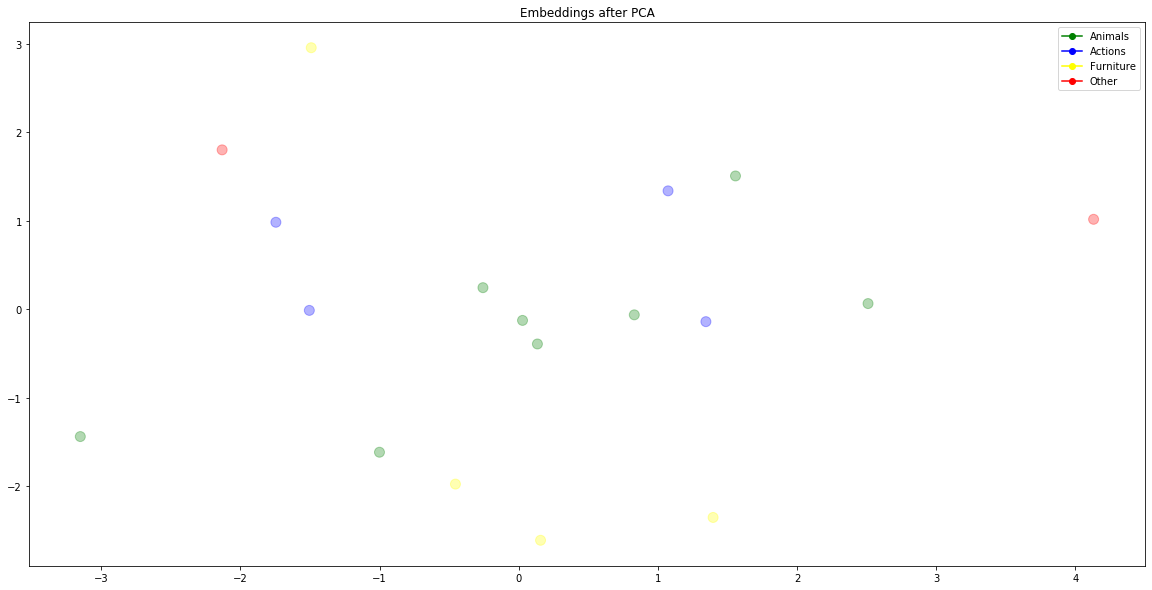

In [0]:
plot_embeddings_after_pca(model.embedding_layer(torch.Tensor(range(vocabulary_size+1)).long()).detach().numpy())

### Applying Word Embeddings

In the next section, we'll see how to apply word embeddings that have been pre-trained.  We'll use embeddings generated using the *FastText* algorithm that was developed by Facebook AI.  It is similar to Word2Vec that we saw above in that it has both CBOW and Skipgram variants, but it performs the actual 'construction' of the embedding in a different way (and was specifically designed for languages that have complex [morphology](https://en.wikipedia.org/wiki/Morphology_(linguistics)).  Facebook has already trained embeddings on a large corpus (in this case, Wikipedia dumps for multiple languages) and makes this data available [on the Facebook Research GitHub site](https://github.com/facebookresearch/fastText/blob/bc1285939f1c216bd358425c3685a049dd8f56c0/docs/crawl-vectors.md).  This link also contains a reference to the paper describing the FastText algorithm.  

We will repeat the small experiment we performed at the beginning of the lab, but this time we will use FastText word embeddings.  Will our classifier be able to generalize?

**Exercise**
What happens when you switch around what objects are allowed on the mat? Will the algorithm be able to learn? Why/why not?
Can you make the algorithm think that only stationery are allowed on the mat? How about only vehicles? How can you test this (edit in the code if you must)?

In [21]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
 amazon_cells_labelled.txt   Exercise2.ipynb    wiki.simple.vec
'ChatBot CNN.ipynb'	     Exercise4.ipynb
 ChatBot.ipynb		     glove.6B.50d.txt


In [22]:
from gensim.models import KeyedVectors

# Load embeddings from the pre-trained file
# The file can be found in Canvas and must be placed in the same directory as the notebook)
fastText_embeddings = KeyedVectors.load_word2vec_format('/content/drive/My Drive/Colab Notebooks/wiki.simple.vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [29]:

import numpy as np

def build_data_set(corpus):
    """
    Iterate over all sentences in the corpus and for each word, copy the embedding to the appropriate indices
    Args:
      corpus - list of individual sentences in the corpus
    Returns:
      X - Matrix of 1-hot encodings of the sentences
    """
    
    # Assume all sentences are of equal length - otherwise we'll need to truncate or pad
    words_in_sentence = len(corpus[0].split(' '))
    
    # Initialize 
    X = np.zeros((len(corpus), words_in_sentence * fastText_embeddings.vector_size))

    for sent_index in range(len(corpus)):
        words = corpus[sent_index].split(' ')
        for word_index in range(len(words)):
            start_index = fastText_embeddings.vector_size * word_index
            end_index = fastText_embeddings.vector_size * (word_index + 1)
            X[sent_index, start_index:end_index] = fastText_embeddings[words[word_index].lower()] 
    
    return X
            

# Train the model - animals are allowed on the mat, other objects are not
animal_training_corpus = [
                   'The cat sat on the mat', 
                   'The dog sat on the mat', 
                   'The goat sat on the mat', 
                   'The elephant sat on the mat', 
                   'The plane sat on the mat', 
                   'The apple sat on the mat', 
                   'The pen sat on the mat', 
                   'The notebook sat on the mat'
                   ]
animal_allowed = np.array([1,1,1,1,0,0,0,0])
# Static are allowed on the mat, other objects are not
static_training_corpus = [
                   'The cat sat on the mat', 
                   'The goat sat on the mat', 
                   'The elephant sat on the mat', 
                   'The plane sat on the mat', 
                   'The car sat on the mat',
                   'The apple sat on the mat', 
                   'The pen sat on the mat', 
                   'The notebook sat on the mat',
                   'The rock sat on the mat',
                   'The house sat on the mat',
                   ]
static_allowed = np.array([0,0,0,0,0,1,1,1,1,1])
vehicules_training_corpus = [
                   'The cat sat on the mat', 
                   'The goat sat on the mat', 
                   'The elephant sat on the mat', 
                   'The plane sat on the mat', 
                   'The car sat on the mat',
                   'The apple sat on the mat', 
                   'The pen sat on the mat', 
                   'The notebook sat on the mat',
                   'The rock sat on the mat',
                   'The house sat on the mat',
                   ]
vehicules_allowed = np.array([0,0,0,1,1,0,0,0,0,0])


animal_X_train = build_data_set(animal_training_corpus)
static_X_train = build_data_set(static_training_corpus)
vehicules_X_train = build_data_set(vehicules_training_corpus)

animal_logistic_embeddings = LogisticRegression()
animal_logistic_embeddings.fit(animal_X_train, animal_allowed)
static_logistic_embeddings = LogisticRegression()
static_logistic_embeddings.fit(static_X_train, static_allowed)
vehicules_logistic_embeddings = LogisticRegression()
vehicules_logistic_embeddings.fit(vehicules_X_train, vehicules_allowed)

        
# Will the network be able to generalize?     
words = ["keyboard", "bird", "book", "car", "lizard", "tree"]   
test_corpus = [ 'The {} sat on the mat'.format(s) for s in words ]
X_test = build_data_set(test_corpus)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
animal_y_test = [0,1,0,0,1,0]
static_y_test = [1,0,1,0,0,1]
vehicules_y_test = [0,0,0,1,0,0]

print("Actual Results for {}: {} (expecting {})".format("Animal",animal_logistic_embeddings.predict(X_test),animal_y_test))
print("Actual Results for {}: {} (expecting {})".format("Static",static_logistic_embeddings.predict(X_test),static_y_test))
print("Actual Results for {}: {} (expecting {})".format("Vehicules",vehicules_logistic_embeddings.predict(X_test),vehicules_y_test))

Actual Results for Animal: [0 1 0 0 1 0] (expecting [0, 1, 0, 0, 1, 0])
Actual Results for Static: [1 0 1 0 0 1] (expecting [1, 0, 1, 0, 0, 1])
Actual Results for Vehicules: [0 0 0 1 0 0] (expecting [0, 0, 0, 1, 0, 0])


### Summary

In this lab, we discussed the use of word embeddings as a way to represent individual words to NLP algorithms.  We went over the issues that affect the Bag-of-Words representation, and saw how word embeddings can solve them.  We then used a small corpus to train our own embeddings, and finally used a pre-trained set of embeddings for solving a text classification problem.

The concept of embeddings and distributed representations is very broad, and it will probably not surprise you to learn that there are techniques and algorithms for computing embeddings for sentences and even entire documents.  In fact, this is a one of the most active areas in NLP research.  These embeddings are able to capture semantic similarities in a domain, and so are ideal as the inputs for other, downstream NLP tasks.  

Finally, here are some best practices for training your own embeddings:
* Use a large corpus of domain-specific texts.  Using a general corpus (like Wikipedia) may affect your model's accuracy and performance for your specific application.  If you do not have a large amount of domain-specific texts, the use of *transfer learning* on pretrained embeddings may help.
* Plan for a training process that will take a long time.  The use of a GPU (or multiple GPUs) is highly recommended.
* You will need to tune both embedding dimensionality and context window size. The choices you make here will directly affect the accuracy of your model and the time required to train it.